In [43]:
import pystan
import numpy as np

%load_ext jupyterstan
%matplotlib inline

The jupyterstan extension is already loaded. To reload it, use:
  %reload_ext jupyterstan


In [4]:
%%stan linear_model

data {
  int<lower=1> N; //sample size
  int<lower=1> K;
  matrix[N, K] X;
  vector[N] y;
}

transformed data {
  
}

parameters {
  vector[K] beta;
  real<lower=0> sigma;
}

transformed parameters {
  
}

model {
  vector[N] mu;
  mu = X * beta;
  
  // priors
  beta ~ normal(0, 10);
  sigma ~ cauchy(0, 5);
  
  // likelihood
  y ~ normal(mu, sigma);
}

generated quantities{
  
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL linear_model_9af967fce5aa7010fb0126053cc76193 NOW.


Creating pystan model & assigning it to variable name "linear_model".
Stan options:
 {'model_name': 'linear_model', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "linear_model"!
Compilation took a minute.


In [34]:
N = 500
alpha = 1
beta = 2
X= np.random.normal(0, 1, N )
prob = 1/(1 + np.exp(-(alpha + beta*X)))
y = np.random.binomial(1, prob)

N_train = int(N * 0.8)
N_test = int(N * 0.2)
index = np.random.permutation(range(N))
x_train = X[index[:N_train]]
y_train = y[index[:N_train]]
x_test = X[index[N_train:]]
y_test = y[index[N_train:]]

In [36]:
%%stan bi_model
data{
  int<lower=1> N_train;
  vector[N_train] x_train;
  int<lower=0, upper=1> y_train[N_train];
  int<lower=1> N_test;
  vector[N_test] x_test;
}

parameters {
  real alpha;
  real beta;
}

model{
  y_train ~ bernoulli_logit(alpha + beta*x_train);
  alpha ~ normal(5, 10);
  beta ~ normal(5, 10);
}

generated quantities{
  vector[N_test] y_test;
  for(i in 1:N_test){
    y_test[i] = bernoulli_rng(inv_logit(alpha + beta*x_test[i]));
  }
}

Creating pystan model & assigning it to variable name "bi_model".
Stan options:
 {'model_name': 'bi_model', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}


INFO:pystan:COMPILING THE C++ CODE FOR MODEL bi_model_a24aa4873c01330810e4b48c2229c29c NOW.


StanModel now available as variable "bi_model"!
Compilation took a minute.


In [24]:
# it requires re-estimating the entire model every time new predictions need to be made.

In [38]:
data = {'N_train':N_train,
                 'x_train':x_train,
                 'y_train':y_train,
                 'N_test':N_test,
                 'x_test':x_test}

In [39]:
data

{'N_train': 400,
 'x_train': array([-0.77286298, -0.50772208,  0.47287398,  0.38024054, -0.55014251,
         0.57301574,  0.77054701, -0.24493858, -0.51031738,  0.45646176,
         0.06456978, -1.23488622, -0.66723612, -1.42866731,  0.57918319,
        -0.59684609,  0.9548338 , -0.51053823, -0.94593497, -0.01626732,
         0.72527068, -0.78770746,  0.90123382, -1.43568424,  0.30743498,
        -0.79322487, -0.73362917, -0.27245822,  0.88910056, -0.2468262 ,
        -0.66310629, -0.23270569,  0.61260741,  0.63174947, -0.00549809,
        -0.21906582,  0.61706574,  0.25213959, -1.22993961, -1.00529489,
        -1.1965465 , -1.37853534, -0.92057673,  0.41771578, -1.25906748,
        -0.9675091 ,  3.07247676, -0.51946085,  0.2808789 , -1.33047554,
         0.27472616,  1.83888843,  0.73378284, -1.32365114,  1.33870932,
         0.69284922, -0.94978372,  1.54983297,  0.44706657,  1.71986651,
        -2.19481564,  0.43728579,  0.78035524, -0.93066193, -0.10509793,
         0.69157009,  0

In [40]:
fit = bi_model.sampling(data=data, chains=3, iter=1000)

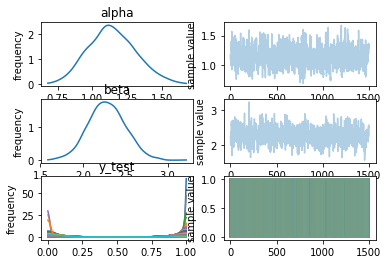

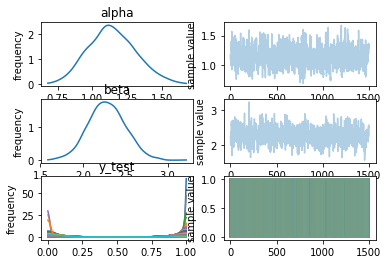

In [44]:
fit.plot()

In [46]:
ext_fit = fit.extract()

In [56]:
result = np.median(ext_fit['y_test'],axis=0)

In [58]:
result

array([1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0.])

In [65]:
np.mean(result == y_test)

0.81

## 重新用python写一个程序用于预测

In [66]:
ext_fit

OrderedDict([('alpha',
              array([1.18422863, 1.02715459, 1.10684889, ..., 0.97239424, 0.92746486,
                     1.0649697 ])),
             ('beta',
              array([2.38458429, 2.40599535, 2.22873863, ..., 2.23246973, 1.98553557,
                     2.03459051])),
             ('y_test', array([[1., 0., 1., ..., 1., 0., 1.],
                     [1., 0., 1., ..., 0., 0., 0.],
                     [1., 0., 1., ..., 0., 0., 1.],
                     ...,
                     [1., 0., 0., ..., 1., 0., 1.],
                     [1., 0., 1., ..., 1., 1., 0.],
                     [1., 0., 1., ..., 1., 1., 1.]])),
             ('lp__',
              array([-148.98129843, -149.59101413, -148.85941079, ..., -149.42649503,
                     -150.05023074, -149.38555239]))])

In [82]:
alpha_post = ext_fit['alpha']
beta_post = ext_fit['beta']

def gen_quant_r(x):
    lin_comb = np.random.choice(alpha_post, size=len(x)) + x*np.random.choice(beta_post, size=len(x))
    prob = 1/(1 + np.exp(-lin_comb))
    out = np.random.binomial(1, prob)
    return out

np.random.seed(2)
y_pred_r = gen_quant_r(x_test)
np.mean(y_pred_r == y_test)

0.76

In [70]:
np.shape(alpha_post)

(1500,)

In [76]:
len(alpha_post)

1500

## Predict with stan

In [83]:
%%stan predict_model
data {
  int N;
  int N_samples;
  vector[N] x_test;
  vector[N_samples] alpha;
  vector[N_samples] beta;
}

parameters {}

model {}

generated quantities {
  matrix[N_samples, N] y_test;
  for(n in 1:N) {
    for(i in 1:N_samples) {
      y_test[i, n] = bernoulli_rng(inv_logit(alpha[i] + beta[i]*x_test[n]));
    }
  }
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL predict_model_3099e5c703fe2ab14c070a056de97abc NOW.


Creating pystan model & assigning it to variable name "predict_model".
Stan options:
 {'model_name': 'predict_model', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "predict_model"!
Compilation took a minute.


In [93]:
data_2 = {'N':N_test, 'N_samples':len(alpha_post),
          'x_test':x_test,
         'alpha':alpha_post, 'beta':beta_post}

In [94]:
pred = predict_model.sampling(data=data_2, chains=1, iter=1000, algorithm='Fixed_param')

In [95]:
ext_pred = pred.extract()

In [101]:
i_idx = np.shape(ext_pred['y_test'])[1]
j_idx = np.shape(ext_pred['y_test'])[2]
out_mat = np.zeros((i_idx, j_idx))
for i in range(i_idx):
    for j in range(j_idx):
        out_mat[i, j] = np.mean(ext_pred['y_test'][:, i, j])


In [102]:
out_mat

array([[0.851, 0.1  , 0.98 , ..., 0.687, 0.193, 0.328],
       [0.817, 0.09 , 0.975, ..., 0.635, 0.147, 0.37 ],
       [0.827, 0.102, 0.981, ..., 0.639, 0.199, 0.387],
       ...,
       [0.833, 0.099, 0.978, ..., 0.642, 0.194, 0.361],
       [0.799, 0.106, 0.974, ..., 0.653, 0.202, 0.379],
       [0.792, 0.127, 0.97 , ..., 0.649, 0.22 , 0.416]])

In [112]:
out = np.mean(out_mat, axis=0)
out = np.where(out > 0.5, 1, 0)
np.mean(out == y_test)

0.81